In [56]:
import numpy as np
import pandas as pd

import missingno as msno

from sqlalchemy import create_engine, MetaData
engine = create_engine('sqlite:///../gains.db')

import cufflinks as cf
cf.go_offline()

## Sleep

In [28]:
sleep = pd.read_csv('sleep.csv', parse_dates = ['dateOfSleep'])

In [11]:
sleep.dateOfSleep.describe()

count                    1170
unique                    909
top       2016-08-18 00:00:00
freq                        6
first     2016-05-26 00:00:00
last      2019-06-21 00:00:00
Name: dateOfSleep, dtype: object

In [35]:
sleep.columns

Index(['dateOfSleep', 'duration', 'efficiency', 'endTime', 'infoCode',
       'levels', 'logId', 'minutesAfterWakeup', 'minutesAsleep',
       'minutesAwake', 'minutesToFallAsleep', 'startTime', 'timeInBed',
       'type'],
      dtype='object')

- Duplicate date entries appear when I the tracker identifies sleep more than once a day
    - Can occur because of naps

In [30]:
sleep.dateOfSleep.is_unique

False

In [31]:
sleep.dateOfSleep.duplicated().sum()

261

In [107]:
check = sleep.groupby('dateOfSleep')[['minutesAsleep']].sum()

In [108]:
dr = pd.date_range(start = check.index.min(), end = check.index.max(), freq = 'D')

In [109]:
check = check.reindex(dr)

- How many days of sleep data are missing

In [110]:
check.isnull().sum()

minutesAsleep    213
dtype: int64

- Total possible years of sleep data

In [146]:
len(check) / 365

3.073972602739726

- Number of years of sleep data I have

In [147]:
check.notnull().sum() / 365

minutesAsleep    2.490411
dtype: float64

- Number of years missing sleep data

In [148]:
check.isnull().sum() / 365

minutesAsleep    0.583562
dtype: float64

- Percentage of sleep data missing

In [156]:
pct_missing = round(check.minutesAsleep.isnull().sum() / len(check), 2)

In [157]:
pct_missing

0.19

- Percentage of sleep data complete

In [162]:
1 - pct_missing

0.81

- Two major gaps in sleep coverage in 2017 and 2018 come from prior Fitbits breaking and having to wait for a replacement. For the second replacement, increasing frequency of missing data seems to indicate the Fitbit's enduring more wear and tear and wearing out over time.

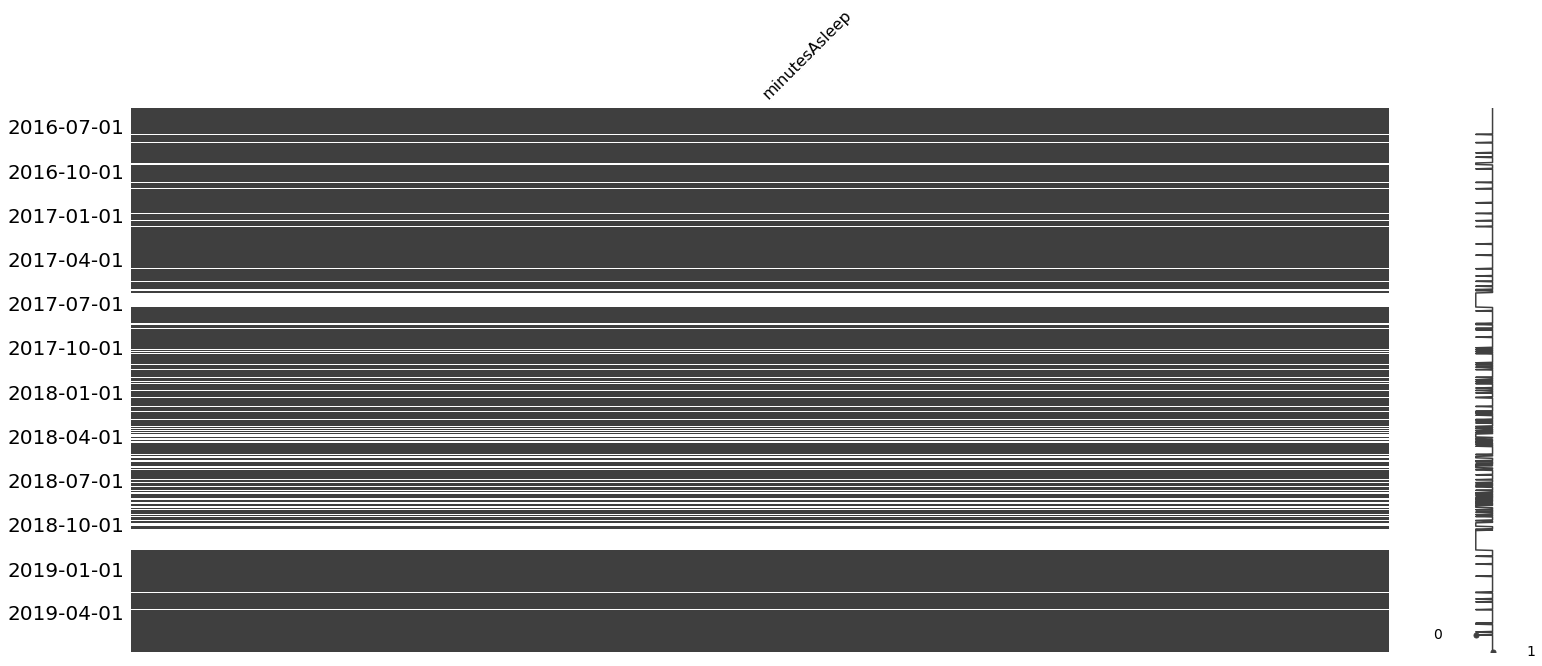

In [158]:
msno.matrix(check, freq = 'QS')

In [159]:
sleep.to_sql('sleep', con = engine, if_exists='replace', index = False)

# Bodyweight

- Missing weight data is slightly different from sleep data. One can expect me to sleep everyday, barring school all-nighters; as a result, data is missing if there isn't a day of sleep. For weight data, the measurements are elective, not automatic. Generally, it would be good to see weight readings at least once a week. At least weekly data will be the standard of missing in this case.

In [165]:
weight = pd.read_csv('weight.csv', parse_dates = ['date'])

In [164]:
weight.head()

,bmi,date,fat,logId,source,time,weight
0,30.37,05/30/16,21.799999,1464652799000,API,23:59:59,224.0
1,30.37,05/31/16,NaN,1464739199000,API,23:59:59,224.0
2,30.37,06/01/16,NaN,1464825599000,API,23:59:59,224.0
3,30.24,06/11/16,21.799999,1465689599000,API,23:59:59,223.0
4,29.83,06/26/16,20.600000,1466985599000,API,23:59:59,220.0


In [166]:
weight.date.describe()

count                     135
unique                    133
top       2019-02-10 00:00:00
freq                        2
first     2016-05-30 00:00:00
last      2019-06-16 00:00:00
Name: date, dtype: object

In [203]:
wdr = pd.date_range(start = weight.date.min(), end = weight.date.max(), freq = 'W')

In [208]:
readings = weight.resample(rule = 'W', on = 'date').weight.count()

In [209]:
len(readings)

159

In [210]:
readings.eq(0).sum()

43

In [211]:
readings.ne(0).sum()

116

In [213]:
readings.eq(0).sum() / readings.ne(0).sum()

0.3706896551724138

In [214]:
readings = readings.mask(readings > 0, 1)

- Largest missing data gap between September and December 2017
- A smaller gap between the end of July and the end of August 2018 while I prepping to go abroad in Argentina for the Y20

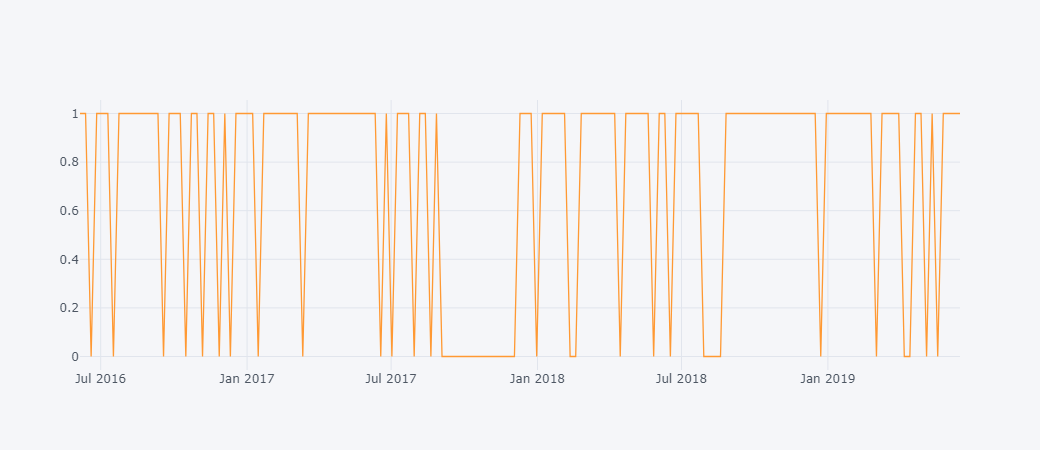

In [216]:
readings.iplot()

In [218]:
weight.to_sql('weight', con = engine, if_exists = 'replace', index = False)

## Resting Heart Rate

In [ ]:
rest = pd.read_csv('resting_heart_rate.csv', parse_dates = ['dateTime'])

In [ ]:
rest.head()

In [ ]:
vals = pd.concat([pd.DataFrame.from_dict(literal_eval(value), orient = 'index').T for value in rest.value],
          sort = False).reset_index(drop = True)

In [ ]:
vals.date = pd.to_datetime(vals.date)

In [ ]:
vals.dropna(inplace = True)

In [ ]:
vals.head()

In [ ]:
vals.to_sql('resting_heart_rate', con = engine, if_exists = 'replace', index = False)

## Calories

In [3]:
import dask
import dask.dataframe as dd

In [39]:
cals = pd.read_csv('calories.csv')

In [40]:
cals.head()

,dateTime,value
0,05/20/16 00:00:00,1.43
1,05/20/16 00:01:00,1.43
2,05/20/16 00:02:00,1.43
3,05/20/16 00:03:00,1.43
4,05/20/16 00:04:00,1.43


In [45]:
para = dd.from_pandas(cals, npartitions = 8)

In [46]:
para.dateTime = dd.to_datetime(para.dateTime, format = '%m/%d/%y %H:%M:%S')

In [47]:
para

,dateTime,value
npartitions=8,,
0,datetime64[ns],float64
196293,...,...
...,...,...
1374051,...,...
1570341,...,...


In [48]:
%%time
fin = para.compute()

Wall time: 9.84 s


In [55]:
fin.head()

,dateTime,value
0,2016-05-20 00:00:00,1.43
1,2016-05-20 00:01:00,1.43
2,2016-05-20 00:02:00,1.43
3,2016-05-20 00:03:00,1.43
4,2016-05-20 00:04:00,1.43


In [57]:
%%time
fin.to_sql('calories', con = engine, index = False, if_exists = 'replace')

Wall time: 27 s


In [57]:
%%time
fin.to_sql('calories', con = engine, index = False, if_exists = 'replace', meh)

Wall time: 27 s


## Time in Heart Rate Zones

In [ ]:
zones = pd.read_csv('time_in_heart_rate_zones.csv', parse_dates = ['dateTime'])

In [ ]:
zs = pd.concat([pd.DataFrame.from_dict(literal_eval(value), orient = 'index') for value in zones.value], sort = False).reset_index(drop = True)

In [ ]:
zones = zones.drop('value', axis = 1).join(zs).rename(columns = str.lower).rename(columns = {'datetime': 'date'})

In [ ]:
zones = zones[['date','below_default_zone_1', 'in_default_zone_1', 'in_default_zone_2', 'in_default_zone_3']]